In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

In [3]:
# Load dataset
df = pd.read_csv("/content/Dataset1.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

In [4]:
# Only keep reliable numeric columns
df = df[['Date', 'Close', 'VWAP', 'Volume', 'Turnover', 'Prev Close']]

In [5]:
# Feature Engineering
df['SMA_3'] = df['Close'].rolling(window=3).mean()
df['EMA_3'] = df['Close'].ewm(span=3, adjust=False).mean()
df['Return'] = df['Close'].pct_change()
df['Volatility'] = df['Return'].rolling(window=3).std()

<ipython-input-5-1bceb2447ea8>:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Return'] = df['Close'].pct_change()


In [6]:
# Drop rows with NaNs
df.dropna(inplace=True)
print("✅ Shape after cleaning & feature engineering:", df.shape)

✅ Shape after cleaning & feature engineering: (9407, 10)


In [7]:
# Define features and target
features = ['SMA_3', 'EMA_3', 'Return', 'Volatility']
X = df[features]
y = df['Close']

In [8]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Train models
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

lgb_model = LGBMRegressor(n_estimators=100, learning_rate=0.1)
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 7525, number of used features: 4
[LightGBM] [Info] Start training from score 1033809.435320


LGBMRegressor()

In [10]:
# Predictions
xgb_pred = xgb_model.predict(X_test)
lgb_pred = lgb_model.predict(X_test)


In [11]:
# Evaluation
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

evaluate(y_test, xgb_pred, "XGBoost")
evaluate(y_test, lgb_pred, "LightGBM")

XGBoost - MAE: 120328.22, RMSE: 345408.25
LightGBM - MAE: 125052.87, RMSE: 407041.72


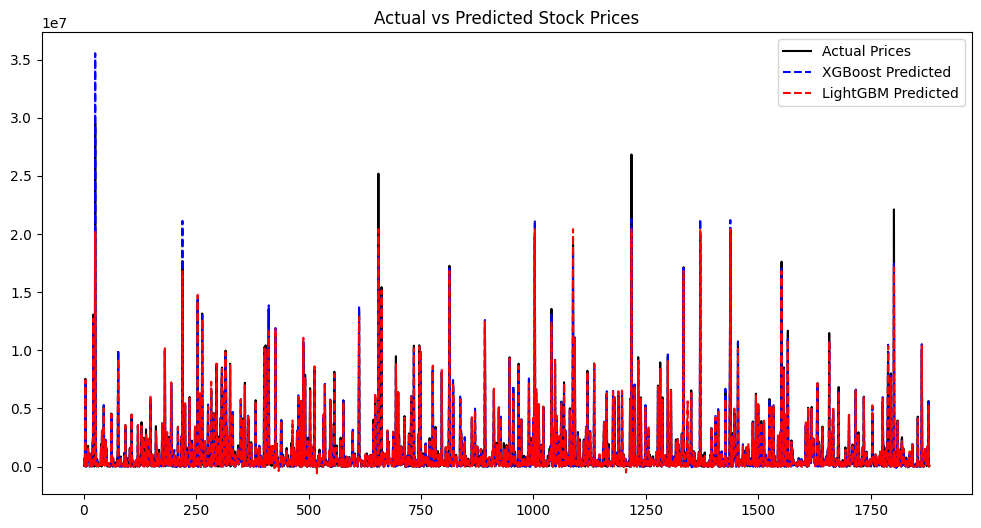

In [12]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual Prices", color='black')
plt.plot(xgb_pred, label="XGBoost Predicted", linestyle='dashed', color='blue')
plt.plot(lgb_pred, label="LightGBM Predicted", linestyle='dashed', color='red')
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.show()

In [13]:
import joblib

# Save models
joblib.dump(xgb_model, 'xgb_stock_model.pkl')
joblib.dump(lgb_model, 'lgb_stock_model.pkl')

# Later, load it back
# xgb_model = joblib.load('xgb_stock_model.pkl')

['lgb_stock_model.pkl']

In [14]:
# Convert actual & predicted prices into UP (1) / DOWN (0) labels
y_test_direction = np.where(y_test.diff().fillna(0) > 0, 1, 0)

xgb_pred_direction = np.where(pd.Series(xgb_pred).diff().fillna(0) > 0, 1, 0)
lgb_pred_direction = np.where(pd.Series(lgb_pred).diff().fillna(0) > 0, 1, 0)


In [15]:
# Function to evaluate classification performance
def evaluate_classification(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_pred)

    print(f"\n📊 {model_name} Direction Prediction Metrics:")
    print(f"✅ Accuracy       : {accuracy:.2f}")
    print(f"✅ Precision      : {precision:.2f}")
    print(f"✅ Recall         : {recall:.2f}")
    print(f"✅ F1 Score       : {f1:.2f}")
    print(f"✅ ROC AUC Score  : {roc_auc:.2f}")

    return confusion_matrix(y_true, y_pred)

In [16]:
# Evaluate both models
xgb_conf_matrix = evaluate_classification(y_test_direction[1:], xgb_pred_direction[1:], "XGBoost")
lgb_conf_matrix = evaluate_classification(y_test_direction[1:], lgb_pred_direction[1:], "LightGBM")



📊 XGBoost Direction Prediction Metrics:
✅ Accuracy       : 0.94
✅ Precision      : 0.94
✅ Recall         : 0.93
✅ F1 Score       : 0.94
✅ ROC AUC Score  : 0.94

📊 LightGBM Direction Prediction Metrics:
✅ Accuracy       : 0.94
✅ Precision      : 0.94
✅ Recall         : 0.93
✅ F1 Score       : 0.94
✅ ROC AUC Score  : 0.94


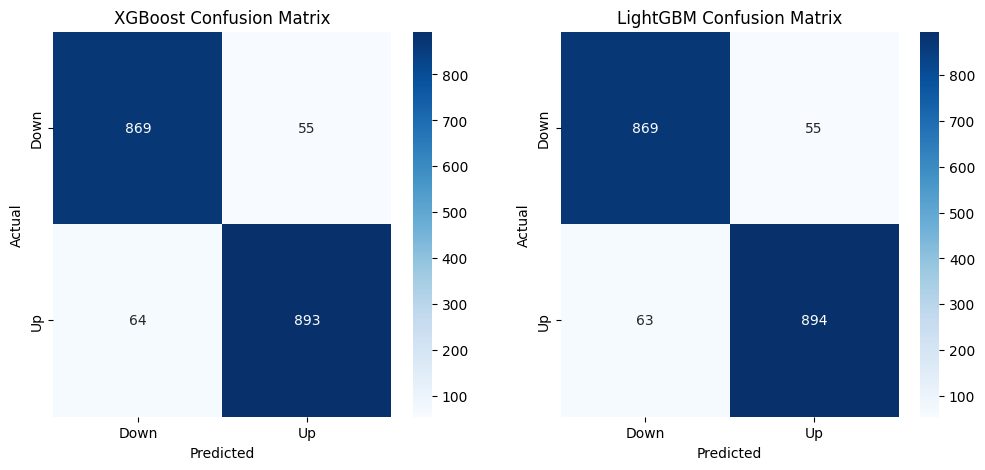

In [17]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, conf_matrix, title in zip(axes, [xgb_conf_matrix, lgb_conf_matrix], ["XGBoost", "LightGBM"]):
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Down", "Up"], yticklabels=["Down", "Up"], ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(f"{title} Confusion Matrix")

plt.show()